<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
params = list(net.parameters()) # learnable parameters of the model
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [6]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0962, -0.1044, -0.0781, -0.0681,  0.0040,  0.0912, -0.0790, -0.0209,
         -0.1435,  0.0150]], grad_fn=<AddmmBackward>)


In [0]:
net.zero_grad() # zero-fy all the gradients

out.backward(torch.randn(1, 10)) # populate all bckward prop parameters with random weights

torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width.

If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [8]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.6882, grad_fn=<MseLossBackward>)


In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [10]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0099, -0.0150, -0.0025, -0.0073, -0.0037,  0.0086])


In [0]:
learning_rate = 0.01 # Updating the weights using SGD - Stochastic Gradient descent 
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [12]:
for f in net.parameters():
  print(f)

Parameter containing:
tensor([[[[-0.0403, -0.2509,  0.2039],
          [ 0.2695,  0.2875,  0.1314],
          [ 0.0495, -0.1852,  0.0204]]],


        [[[ 0.0088, -0.2980,  0.1891],
          [-0.2994, -0.1509,  0.2161],
          [-0.2391, -0.2419,  0.2981]]],


        [[[ 0.2011,  0.1321,  0.2517],
          [ 0.0253, -0.2289,  0.0757],
          [-0.2415, -0.0801, -0.1236]]],


        [[[ 0.1038,  0.0831,  0.3121],
          [-0.3009,  0.1306, -0.1773],
          [-0.2855,  0.0431, -0.1962]]],


        [[[ 0.1103, -0.0521, -0.1923],
          [-0.1159, -0.1225,  0.2292],
          [-0.2351,  0.0835,  0.2807]]],


        [[[-0.2103,  0.0991,  0.2963],
          [-0.1925,  0.2499, -0.2745],
          [-0.2112,  0.0464,  0.2388]]]], requires_grad=True)
Parameter containing:
tensor([-0.2900, -0.0019, -0.0413, -0.3240, -0.2606, -0.0230],
       requires_grad=True)
Parameter containing:
tensor([[[[-1.1370e-01, -8.8005e-02, -5.8358e-02],
          [ 1.3507e-01, -1.0970e-01,  9.3921e-03

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we built a small package: torch.optim that implements all these methods. Using it is very simple:

In [0]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

################################################################################

We will now create an image classifier


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [15]:
#The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
!ls data/cifar-10-batches-py/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


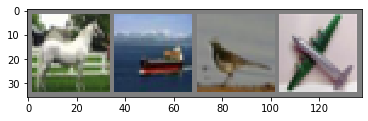

horse  ship  bird plane


In [19]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.215
[1,  4000] loss: 1.845
[1,  6000] loss: 1.688
[1,  8000] loss: 1.606
[1, 10000] loss: 1.501
[1, 12000] loss: 1.454
[2,  2000] loss: 1.377
[2,  4000] loss: 1.339
[2,  6000] loss: 1.331
[2,  8000] loss: 1.280
[2, 10000] loss: 1.290
[2, 12000] loss: 1.244
Finished Training


In [0]:
# Saving the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

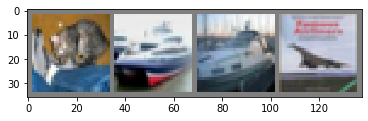

GroundTruth:    cat  ship  ship plane


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
outputs = net(images)

In [27]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    cat  ship  ship plane


In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 78 %
Accuracy of  bird : 38 %
Accuracy of   cat : 25 %
Accuracy of  deer : 51 %
Accuracy of   dog : 39 %
Accuracy of  frog : 78 %
Accuracy of horse : 63 %
Accuracy of  ship : 67 %
Accuracy of truck : 49 %


In [30]:
10+2

12

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [32]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
inputs, labels = data[0].to(device), data[1].to(device)

In [34]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.198
[1,  4000] loss: 1.175
[1,  6000] loss: 1.197
[1,  8000] loss: 1.180
[1, 10000] loss: 1.157
[1, 12000] loss: 1.186
[2,  2000] loss: 1.179
[2,  4000] loss: 1.191
[2,  6000] loss: 1.192
[2,  8000] loss: 1.172
[2, 10000] loss: 1.178
[2, 12000] loss: 1.175
Finished Training
